<a href="https://colab.research.google.com/github/Yaron-Grushka/music-genre-classification/blob/main/Large_Data_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the large dataset


#imports 

In [ ]:

from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import math 
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import torch.nn.functional as F
import requests
import torchvision.models as vision_models

from torch.autograd import Variable

# The dataset

In [ ]:
testdir= '/content/drive/MyDrive/model/test/'
traindir= '/content/drive/MyDrive/model/train/'
BATCH_SIZE = 32

transform = transforms.Compose([transforms.Resize(244),
                                transforms.CenterCrop(244),                              
                                transforms.ToTensor()])

trainset = datasets.ImageFolder(traindir, transform=transform)
testset = datasets.ImageFolder(testdir, transform=transform)


trainloader =  torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)


In [ ]:
print(len(trainset))
print(len(testset))

7190
1800


# Helper Functions 

In [ ]:
def test_loss(net, criterion, test_loss_history):
  net.eval()
  running_loss = 0.0
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU
      output = net(inputs)
      loss = criterion(output, labels)
      running_loss += loss.item()
    print(f'test loss - {running_loss/len(testloader)}')
    test_loss_history.append(running_loss/len(testloader))


def train_network(net, EPOCHS):
  criterion = nn.CrossEntropyLoss()
  learning_rate=0.001
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  train_loss_history = []
  test_loss_history = []
  
  for epoch in range(EPOCHS):
      correct = 0
      loss = 0
      net.train()
      for batch_idx, (X_batch, y_batch) in enumerate(trainloader):
          var_X_batch = Variable(X_batch).float().cuda()
          var_y_batch = Variable(y_batch).cuda()
          optimizer.zero_grad()
          output = net(var_X_batch)
          loss = criterion(output, var_y_batch)
          loss.backward()
          optimizer.step()

          # Total correct predictions
          predicted = torch.max(output.data, 1)[1] 
          correct += (predicted == var_y_batch).sum()
          if batch_idx % 50 == 0:
              print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, batch_idx*len(X_batch), len(trainloader.dataset), 100.*batch_idx / len(trainloader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
      
      train_loss_history.append(loss)
      test_loss(net, criterion, test_loss_history)

  return train_loss_history, test_loss_history


def plot_loss(train_loss_history, test_loss_history, acc, description):
  # Plot the loss over the epochs
  plt.plot(np.arange(len(train_loss_history)) + 1, train_loss_history, color='b', label='Train') 
  plt.plot(np.arange(len(test_loss_history)) + 1, test_loss_history, color = 'r', label='Test')

  plt.title(f'Changes to model: {description}\nTest accuracy: {str(round(acc, 3))}%')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()

def calc_accuracy(net):
  print(net.eval())
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.cuda(), labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (acc))
  return acc


# Our Model

In [ ]:
class CNN_FINAL(nn.Module):
    def __init__(self,original_model=None):
        super(CNN_FINAL, self).__init__()
        
       # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 9)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        # Normalizations:
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()


    def forward(self, x):
      # Convolutional layers:
      x = self.batchnorm1(self.conv1(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm2(self.conv2(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm3(self.conv3(x))
      x = F.max_pool2d(F.relu(x), 4)
      x = self.batchnorm4(self.conv4(x))
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return F.log_softmax(x,dim=1)

    def _init_weights(self, layer) -> None:
      if isinstance(layer, nn.Conv1d):
          nn.init.kaiming_uniform_(layer.weight)
      elif isinstance(layer, nn.Linear):
          nn.init.xavier_normal_(layer.weight)

    

# Training the model and ploting the graphs

Epoch : 0 [0/7190 (0%)]	Loss: 5.523840	 Accuracy:3.125%
Epoch : 0 [1600/7190 (22%)]	Loss: 2.129506	 Accuracy:12.010%
Epoch : 0 [3200/7190 (44%)]	Loss: 1.887488	 Accuracy:17.172%
Epoch : 0 [4800/7190 (67%)]	Loss: 1.914082	 Accuracy:20.344%
Epoch : 0 [6400/7190 (89%)]	Loss: 1.795534	 Accuracy:23.336%
test loss - 1.6807918292388582
Epoch : 1 [0/7190 (0%)]	Loss: 1.622849	 Accuracy:28.125%
Epoch : 1 [1600/7190 (22%)]	Loss: 1.349411	 Accuracy:38.174%
Epoch : 1 [3200/7190 (44%)]	Loss: 1.352379	 Accuracy:38.923%
Epoch : 1 [4800/7190 (67%)]	Loss: 1.630461	 Accuracy:39.901%
Epoch : 1 [6400/7190 (89%)]	Loss: 1.401053	 Accuracy:41.604%
test loss - 1.3825436752747025
Epoch : 2 [0/7190 (0%)]	Loss: 1.582251	 Accuracy:50.000%
Epoch : 2 [1600/7190 (22%)]	Loss: 1.365515	 Accuracy:51.409%
Epoch : 2 [3200/7190 (44%)]	Loss: 1.175446	 Accuracy:51.980%
Epoch : 2 [4800/7190 (67%)]	Loss: 1.282907	 Accuracy:52.028%
Epoch : 2 [6400/7190 (89%)]	Loss: 1.313574	 Accuracy:52.690%
test loss - 1.2940170379322873
Epoch

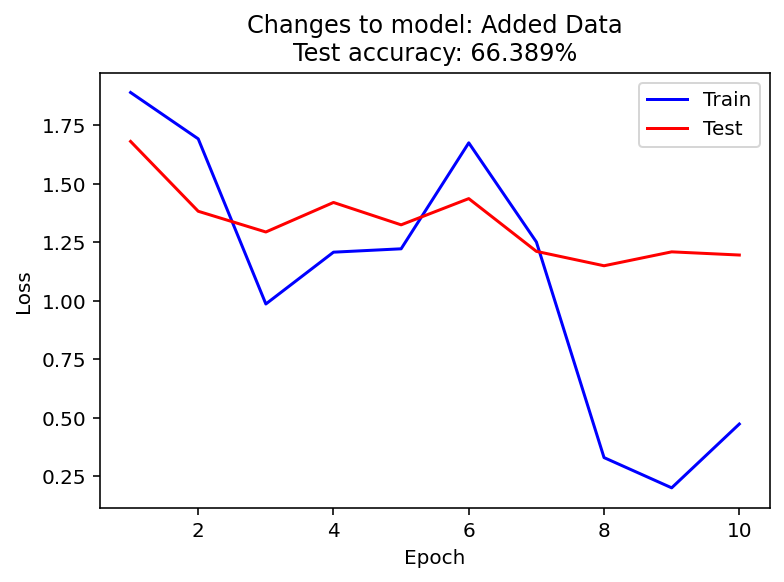

In [ ]:
epoch_number = 10
net = CNN_FINAL().cuda()
train_loss_history, test_loss_history = train_network(net, epoch_number)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'Added Data')

# Ploting the majority vote graphes and workring on a single instense 

In [ ]:
from collections import Counter 
import librosa
import soundfile as sf
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

label_dict = trainloader.dataset.class_to_idx

def get_image(path):
  image = Image.open(path).convert("RGB")
  image = transform(image).float().cuda()
  image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
  return image

def predict_image(net,image):
  net.eval()  
  with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs.data, 1)
    key = next(key for key, value in label_dict.items() if value == int(predicted))
    return key

def test_accurecy_per_genere(genre):
  net.eval()
  print(genre)
  print('__________________________')
  with torch.no_grad():
    counter = 0
    genere_dir= '/content/drive/MyDrive/model/test/'+genre
    for i in range(20):
      prediction =[]
      for j in range(10):
        prefix ='000'
        if i < 10:
          prefix+='0'
        filename = f'{genere_dir}/{genre}.{prefix}{i}{j}.png'
        image = get_image(filename)
        key = predict_image(net,image)
        print(f'\t {genre}.{prefix}{i}{j},   prediction = {key}')
        prediction.append(key)
        #prediction[key] = prediction.setdefault(key,0)+1
      value = Most_Common(prediction)
      print(f'\n \t song number {i}, final prediction: {value}\n_____________\n')
      correct = value==genre
      print(correct)
      counter += 1 if correct else 0
    return counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

def test_all_genre():
  counter = 0
  genere_hist = {}
  for genre in ['blues','classical','disco','hiphop','jazz','metal','pop','reggae','rock']:
    genere_acc = test_accurecy_per_genere(genre)
    counter += genere_acc
    genere_hist[genre] = genere_acc
  print(genere_hist)
  return genere_hist, counter

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def create_image_from_wav(path,offset):
    y, sr = librosa.load(path,offset=offset,duration=3.0)
    S = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=128)
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max))
    plt.savefig('mel_temp.png')
    return image_loader('mel_temp.png')


def predict_new_instance(net,path):
  predictions =[]
  for offset in range(0,30,3):
    image = create_image_from_wav(path,offset)
    prediction = predict_image(net,image)
    predictions.append(prediction)
    plt.imshow(image[0].permute(1, 2, 0).cpu())
    plt.title(prediction)
    plt.show()

  print(f'The finel prediction is {Most_Common(predictions)}')







In [ ]:
history, acc = test_all_genre()


blues
__________________________
	 blues.000000,   prediction = blues
	 blues.000001,   prediction = rock
	 blues.000002,   prediction = blues
	 blues.000003,   prediction = blues
	 blues.000004,   prediction = disco
	 blues.000005,   prediction = hiphop
	 blues.000006,   prediction = blues
	 blues.000007,   prediction = disco
	 blues.000008,   prediction = blues
	 blues.000009,   prediction = blues

 	 song number 0, final prediction: blues
_____________

True
	 blues.000010,   prediction = blues
	 blues.000011,   prediction = hiphop
	 blues.000012,   prediction = jazz
	 blues.000013,   prediction = blues
	 blues.000014,   prediction = reggae
	 blues.000015,   prediction = blues
	 blues.000016,   prediction = blues
	 blues.000017,   prediction = hiphop
	 blues.000018,   prediction = blues
	 blues.000019,   prediction = hiphop

 	 song number 1, final prediction: blues
_____________

True
	 blues.000020,   prediction = hiphop
	 blues.000021,   prediction = blues
	 blues.000022,   predi

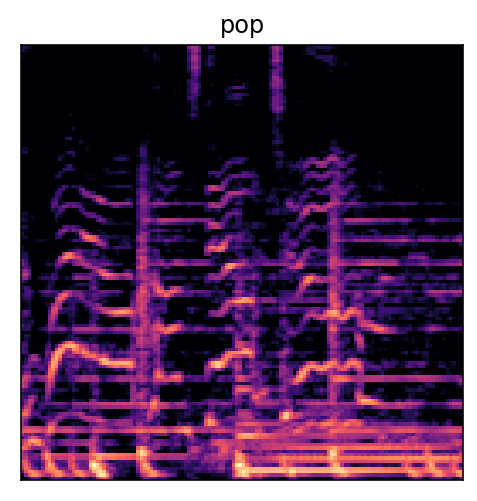

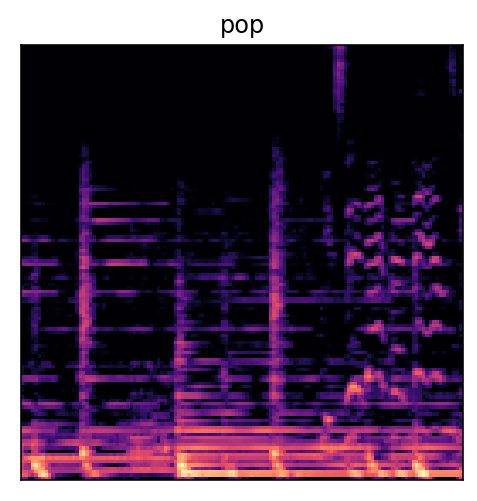

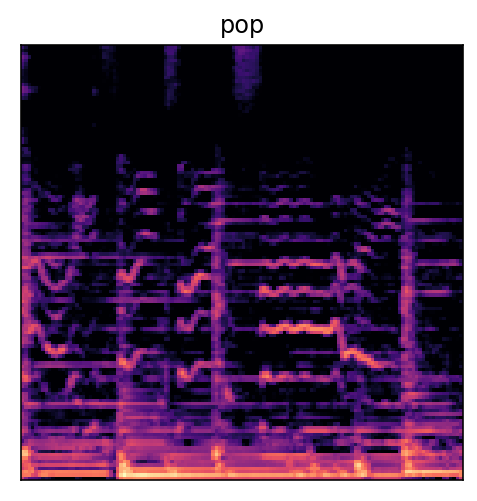

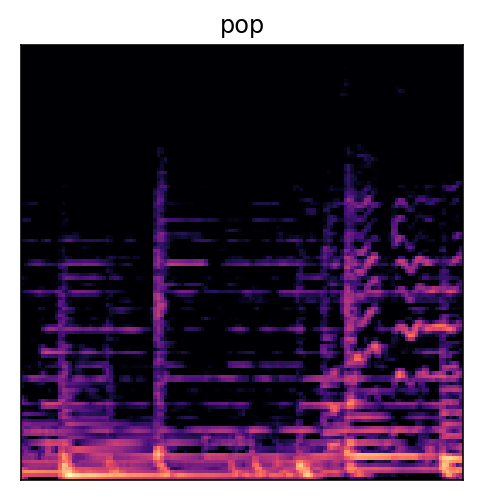

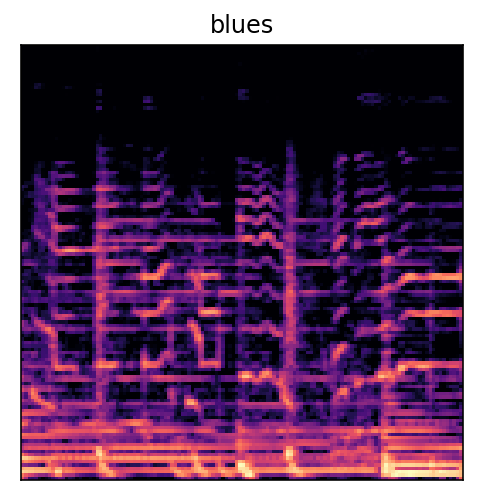

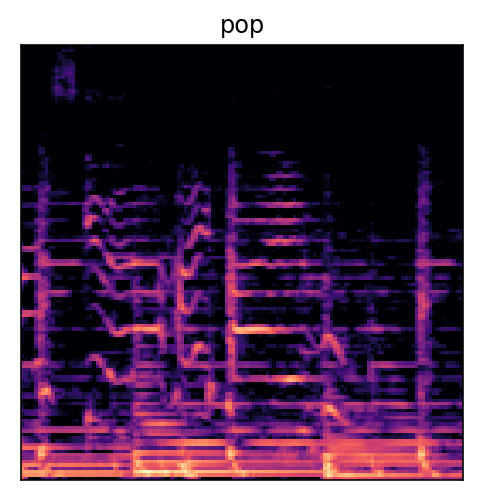

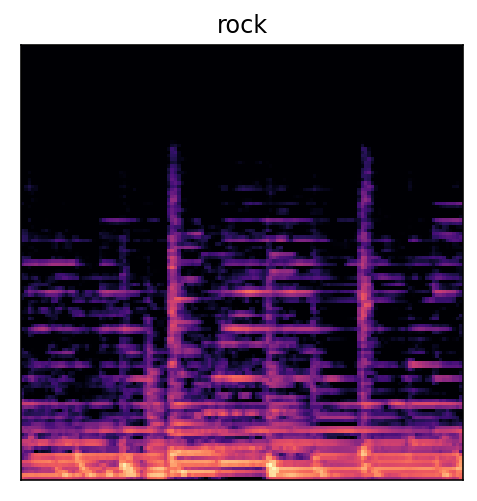

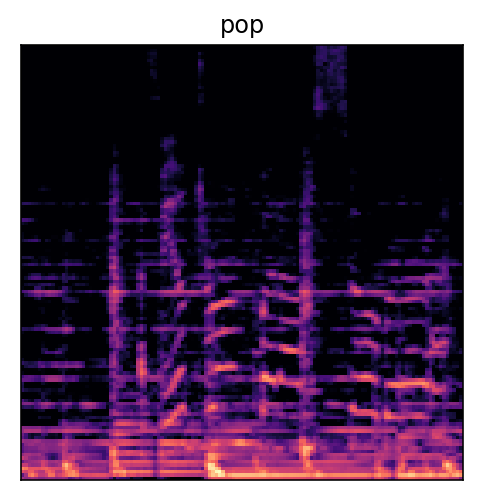

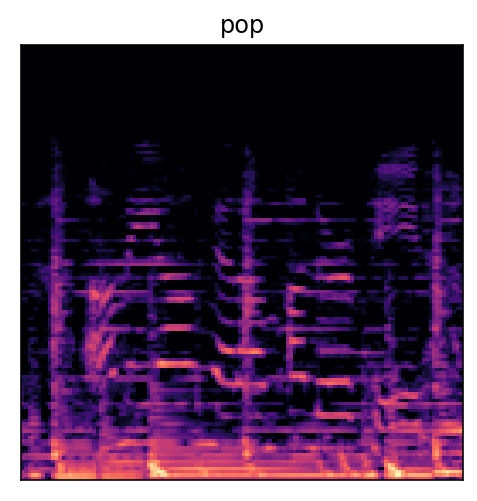

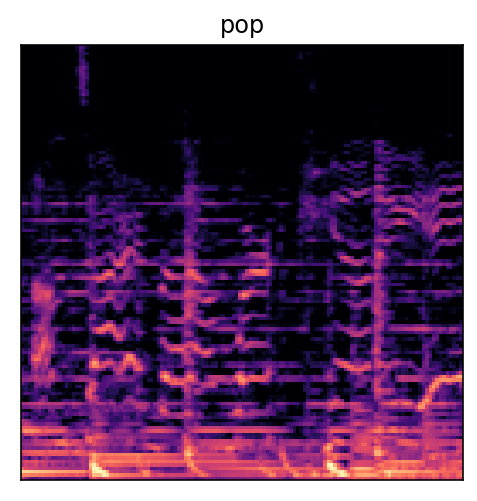

The finel prediction is pop


In [ ]:
predict_new_instance(net,'/content/drive/MyDrive/model/old_data/Data/genres_original/pop/pop.00003.wav')

# Final Accurecy

In [ ]:
print(100 * (acc/180))

75.55555555555556


# Accurecy per genre

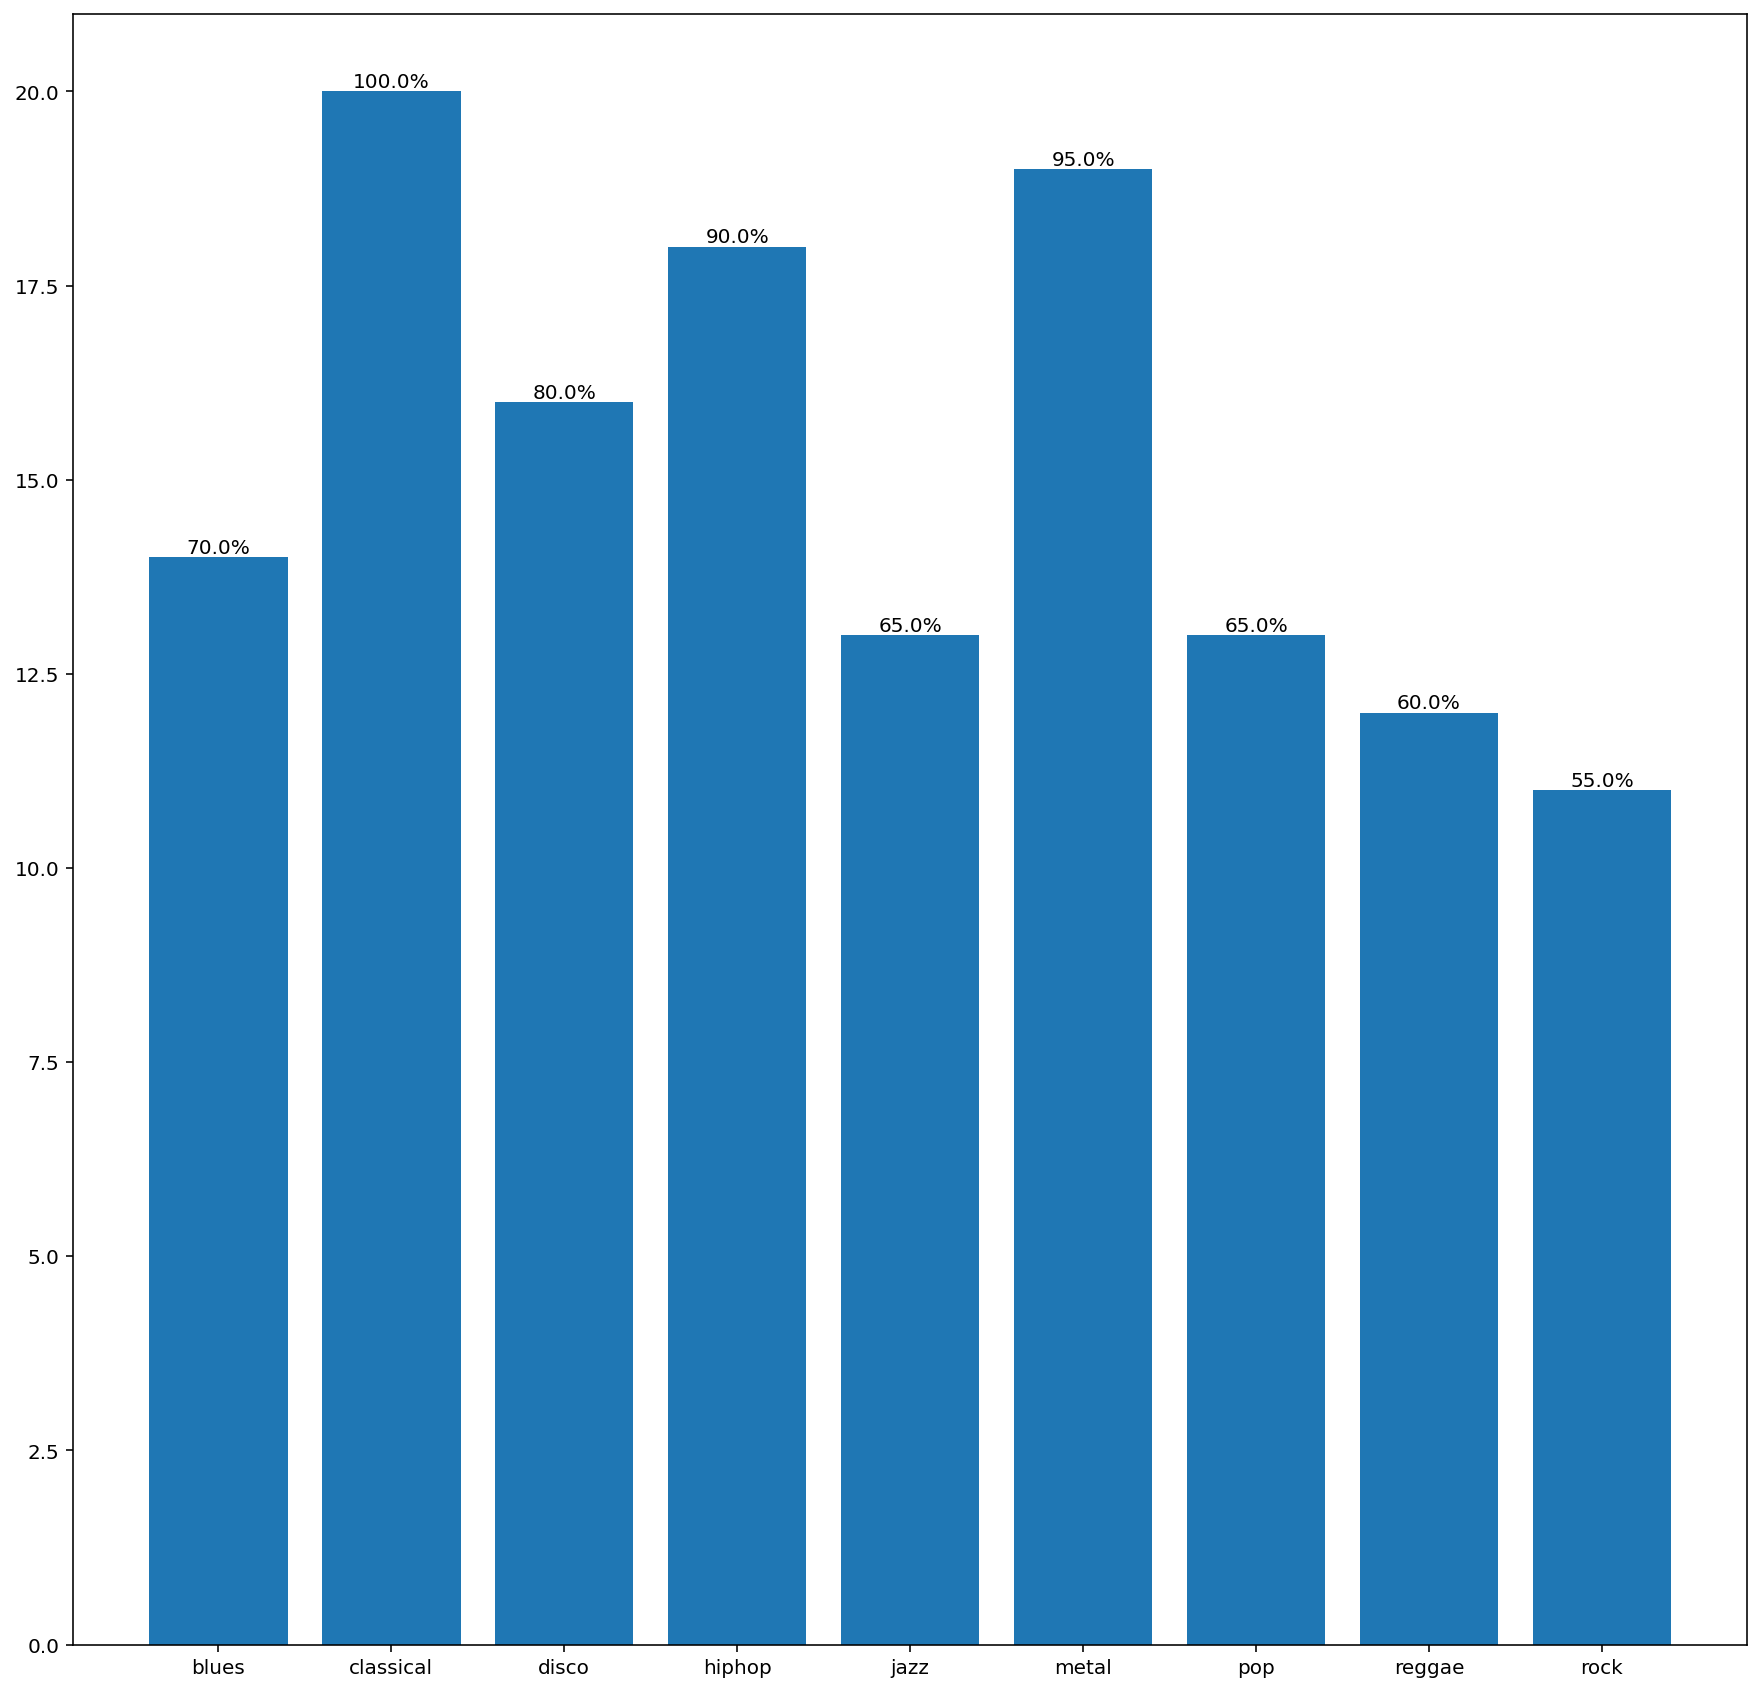

In [ ]:
plt.figure(figsize=(15,15))
bar_plot = plt.bar(history.keys(), history.values(), align='center')
bar_label = list(history.values())
for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{str(round(100*(bar_label[idx]/20),2))}%',
                ha='center', va='bottom', rotation=0)


#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
nb_classes = 9

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
net.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
conf_mat = conf_mat/200 

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
 


[[ 98   2   4  39  16   0  15  21   5]
 [  0 200   0   0   0   0   0   0   0]
 [  0   1 130  16   0   1  42   0  10]
 [  0   0   7 171   0  15   7   0   0]
 [ 21  43   0   4 115   0   6   1  10]
 [  0   0   3   3   0 176   2   0  16]
 [  5  11  13   7   1  10 122   1  30]
 [  5   0  36  39   0   0  15 103   2]
 [ 17   7   7  26   1  44  10   8  80]]
[[0.49  0.01  0.02  0.195 0.08  0.    0.075 0.105 0.025]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.005 0.65  0.08  0.    0.005 0.21  0.    0.05 ]
 [0.    0.    0.035 0.855 0.    0.075 0.035 0.    0.   ]
 [0.105 0.215 0.    0.02  0.575 0.    0.03  0.005 0.05 ]
 [0.    0.    0.015 0.015 0.    0.88  0.01  0.    0.08 ]
 [0.025 0.055 0.065 0.035 0.005 0.05  0.61  0.005 0.15 ]
 [0.025 0.    0.18  0.195 0.    0.    0.075 0.515 0.01 ]
 [0.085 0.035 0.035 0.13  0.005 0.22  0.05  0.04  0.4  ]]
[ 49.  100.   65.   85.5  57.5  88.   61.   51.5  40. ]


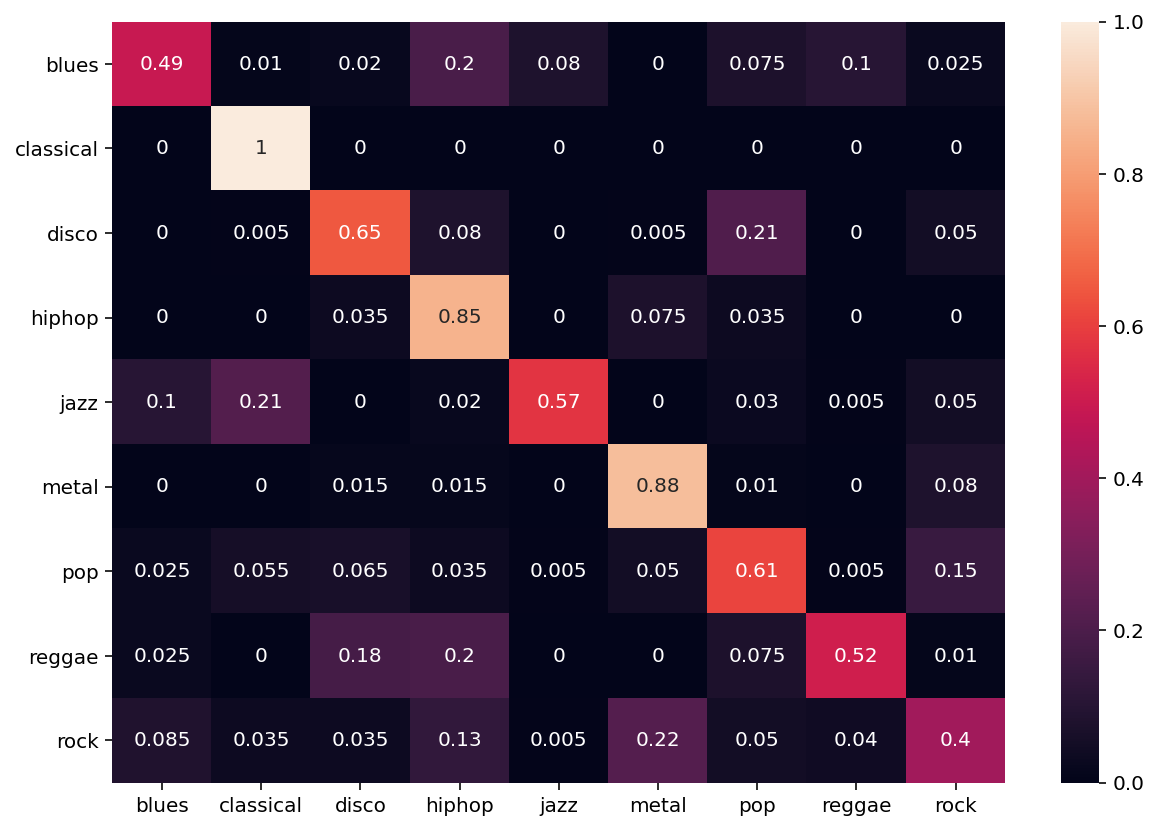

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(conf_mat, index = [i for i in  ['blues','classical','disco','hiphop','jazz','metal','pop','reggae','rock']],
                  columns = [i for i in  ['blues','classical','disco','hiphop','jazz','metal','pop','reggae','rock']])
plt.figure(figsize = (10,7))
#plt.xlabel('Predicted Labels')
#plt.ylabel('True Labels')


sn.heatmap(df_cm, annot=True)